# Model Ensemble: Toy example

1. The goal of this exercise is to combine different models and get uncertainty of estimates using an **ensemble model**.
2. We predict the median LE (data = `LA_uncertainty.dta`) just to simplify. 
3. We use three different regression models: Ridge, Random Forest, K-Neighbors. We can include others later (e.g., logistic or boxcox.
4. The estimate is the first different in LE of increasing GDP by one standard deviation. 

In [613]:
# load packages
from sklearn.base import TransformerMixin
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.utils import resample
import sklearn.metrics as met
import numpy as np
import pandas as pd
from sklearn_pandas import DataFrameMapper, cross_val_score
from utils import utils as f # my functions
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

Here it is the definition classes and models:

In [628]:
# define model transformers

# class LinearTransformer(LinearRegression, TransformerMixin):

#     def transform(self, X, *_):
#         return self.predict(X).reshape(-1,1)
    
class RidgeTransformer(Ridge, TransformerMixin):

    def transform(self, X, *_):
        return self.predict(X).reshape(-1,1)

class RandomForestTransformer(RandomForestRegressor, TransformerMixin):

    def transform(self, X, *_):
        return self.predict(X).reshape(-1,1)

class KNeighborsTransformer(KNeighborsRegressor, TransformerMixin):

    def transform(self, X, *_):
        return self.predict(X).reshape(-1,1)

We combine predictions generated from these models and use them to **predict** the actual outcome (for now the median of LE, a fixed valued). We weight those predictions using linear regression, although we could use any other model (e.g., random forest, xgboost). For now, let's keep it simple. 

- For Ridge regression, GDP is first standardized, and then polynomial transformations of features were computed.
- Random Forest and K-Neighbors use the default set up. 

In [650]:
# function to create model
def build_model():

#     linear_regression = Pipeline(steps=[
#         ('scaler', StandardScaler()),
#         ('linear', LinearTransformer())
#     ])

    ridge_transformer = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('poly_feats', PolynomialFeatures()),
        ('ridge', RidgeTransformer())
    ])
    
    pred_union = FeatureUnion(
        transformer_list=[
#             ('linear_reg', linear_regression),
            ('ridge', ridge_transformer),
            ('rand_forest', RandomForestTransformer()),
            ('knn', KNeighborsTransformer())
        ],
    )

    # return combination of predictions
    model = Pipeline(steps=[
        ('pred_union', pred_union),
        ('lin_regr', LinearRegression()) # linear combination
    ])

    return model

# Run an individual example

In [651]:
# read the data
df = pd.read_stata('../data/LA_uncertainty.dta')

In [652]:
# df = pd.read_stata('../data/LA_uncertainty_2016.dta')

In [653]:
df.shape

(383, 56)

In [654]:
# select variables
df = df.loc[:, ['year', 'ctry', 'gdp_pc', 'median']]

In [655]:
# some missing data
f.missing_data(df)

gdp_pc    0.101828
median    0.002611
dtype: float64

In [656]:
# remove missing data

In [657]:
df = df.dropna()
df.shape # very small dataset

(343, 4)

In [658]:
# slected features
X, y = df['gdp_pc'].as_matrix().reshape(-1, 1), df['median'].as_matrix()

# define training set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    stratify=df.ctry)

In [659]:
# instance of model and fit
model = build_model()
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('pred_union', FeatureUnion(n_jobs=1,
       transformer_list=[('ridge', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly_feats', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', RidgeTransformer(...=None)), ('lin_regr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [660]:
# predictions 
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)

In [661]:
# overfitting in action
print('MSE training: ', str(met.mean_squared_error(y_train, pred_train)))
print('MSE test: ', str(met.mean_squared_error(y_test, pred_test)))

MSE training:  21.5221500256
MSE test:  247.614787647


In [662]:
# counterfactual and first difference

In [663]:
X_train_cf = X_train + np.std(X_train) # + 1 SD GDP
pred_train_cf = model.predict(X_train_cf)
print('Mean first difference: ', str(np.mean(pred_train_cf - pred_train)))

Mean first difference:  12.901770499


# Uncertainty

The easiest way to do it is to bootstrap estimates of the **first difference**. 

Below, pretty straightforward function to do it.

In [664]:
# bootstrap function
def bootstrap(estimator, X, y, samples=1000, sample_size=.70): 
    
    # list to save results
    stats = []
    nrows = y.shape[0]
    
    # loop
    for s in range(0, samples):
        idx = np.random.choice(nrows, int(len(y)*sample_size), replace=True)
        ty = y[idx]
        tX = X[idx]
        
        model.fit(tX, ty)
        pred = model.predict(tX)
        pred_cf = model.predict(tX + np.std(tX))
        stats.append(np.mean(pred_cf-pred))
    return stats

In [665]:
estimates = bootstrap(model, X_train, y_train, samples=2000, sample_size=0.50)

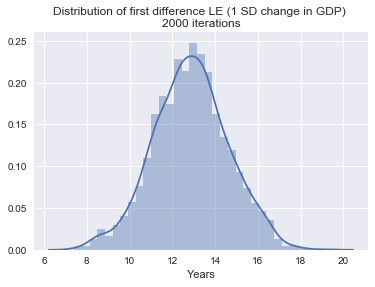

In [667]:
sns.distplot(estimates)
plt.title('Distribution of first difference LE (1 SD change in GDP) \n2000 iterations')
plt.xlabel('Years');